In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
#导入所需的包

In [3]:
file = "lstm_train.csv"
#导入数据
data = pd.read_csv(file)
print(data.head(5))
#查看导入数据的格式
df = DataFrame(data)
#将数据转换为DataFrame以便于后续操作

   time  throughput
0   0.0    2.852570
1   0.5    3.599259
2   1.0    2.166463
3   1.5    1.249071
4   2.0    1.045936


1.1462006500302686
1.8822432365655744
1.7347113749858654
1.6825998522821461
1.3675852013727745
1.5377295918513698
1.3462119695423886
1.5895995622236412
1.492470667479448
1.8398285189937178


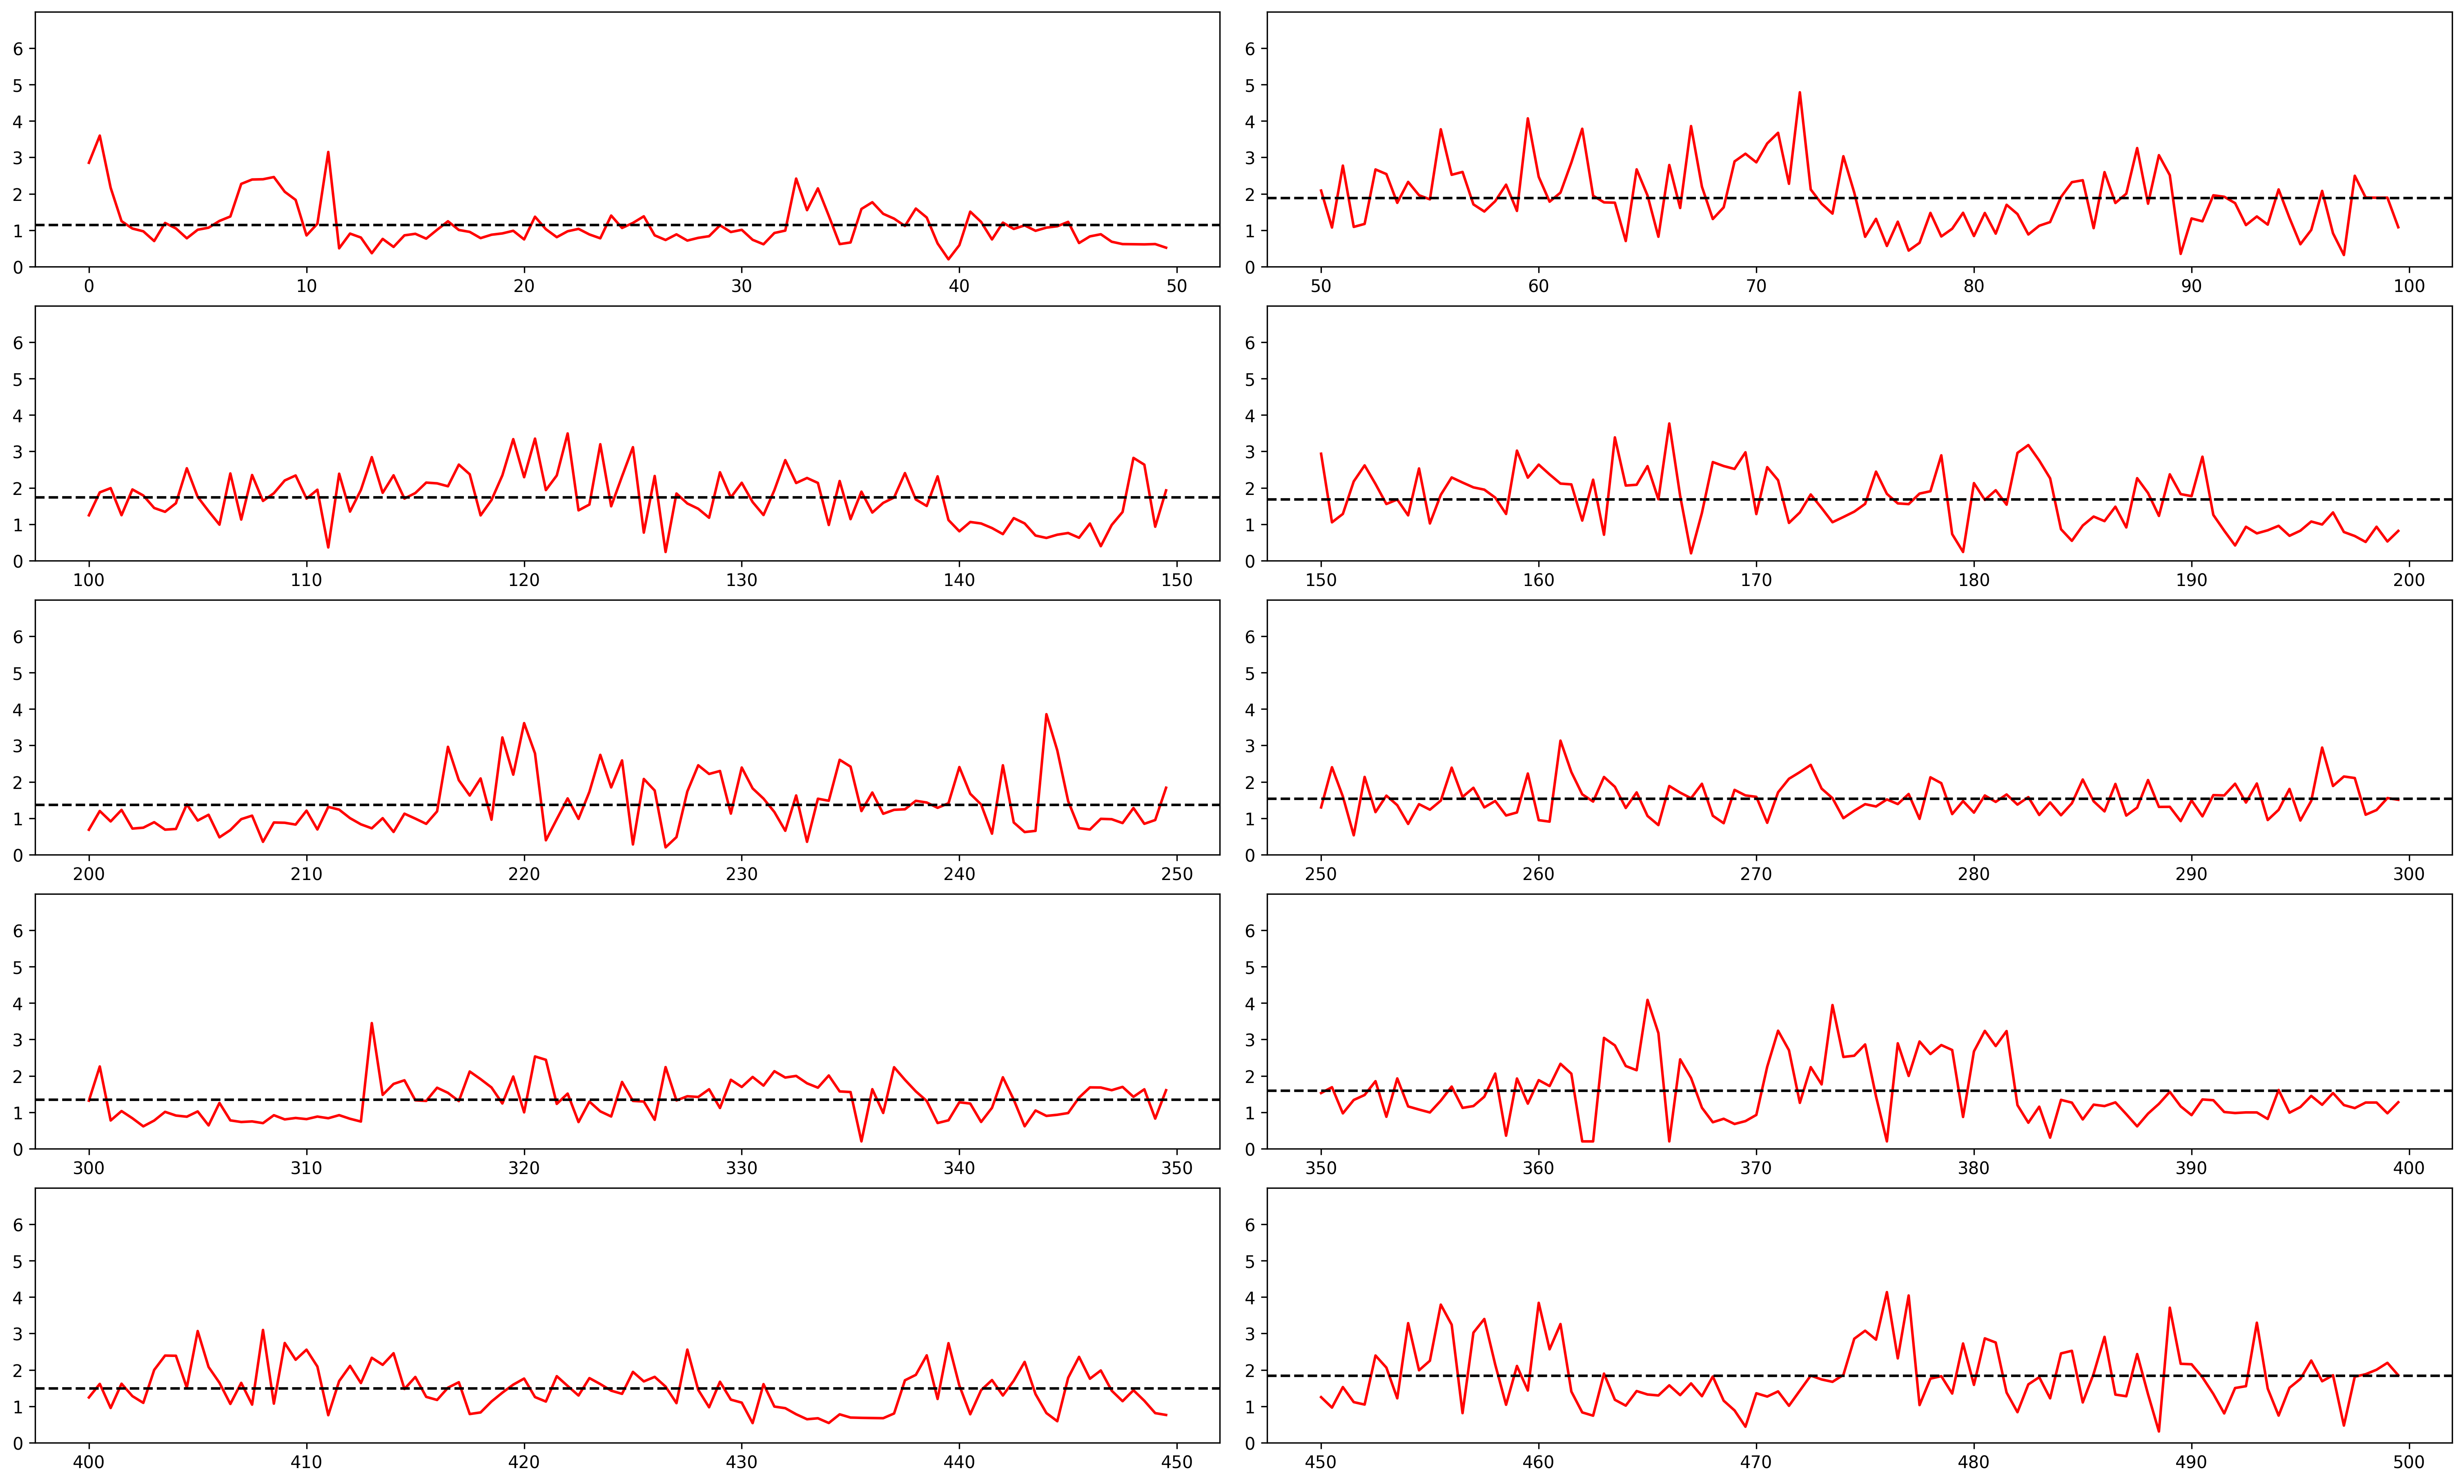

In [4]:
#绘制网络带宽与时间的关系图，观察其中的关系
fig = plt.figure(dpi=300,figsize=(20,12),constrained_layout=True)
for i in range(0,10):
    ax= fig.add_subplot(5,2,i+1)
    df_data = df[100*i:100*(i+1)]
    time = df_data['time']
    through = df_data['throughput']
    print(np.average(through))
    ax.plot(time,through,color='r')
    avg = np.average(through)
    ax.axhline(y = avg,color='black', linestyle='dashed')
    ax.set_xticks(range(50*i,50*(i+1)+1,10))
    ax.set_ylim([0,7])
    ax.set_yticks(range(0,7,1))
plt.show()

In [5]:
#从上图可以看出网络带宽的波动很大，且其波动范围较大，但其仍旧围绕着一个固定的值波动，那个值在1.5左右

In [9]:
import statsmodels.stats.diagnostic

lags = [4,8,16,32]
LB = statsmodels.stats.diagnostic.acorr_ljungbox(df['throughput'],lags = lags,return_df = True)
print("throughput的检验结果:\n",LB)

throughput的检验结果:
         lb_stat  lb_pvalue
4   2219.424972        0.0
8   3401.794046        0.0
16  4281.886803        0.0
32  4527.233048        0.0


In [11]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df["throughput"],autolag='BIC')
dfoutput = pd.Series(dftest[0:4], index=['adf','p-value','usedlag','Number of Observations Used'])
print("单位根检验结果:\n",dfoutput)

单位根检验结果:
 adf                           -1.827264e+01
p-value                        2.317750e-30
usedlag                        5.000000e+00
Number of Observations Used    5.874000e+03
dtype: float64


       through
time          
0     1.614305
1     2.002268
2     1.717042
3     1.064704
4     1.760716
...        ...
1995  0.936088
1996  1.006562
1997  0.828889
1998  0.788226
1999  0.924227

[2000 rows x 1 columns]


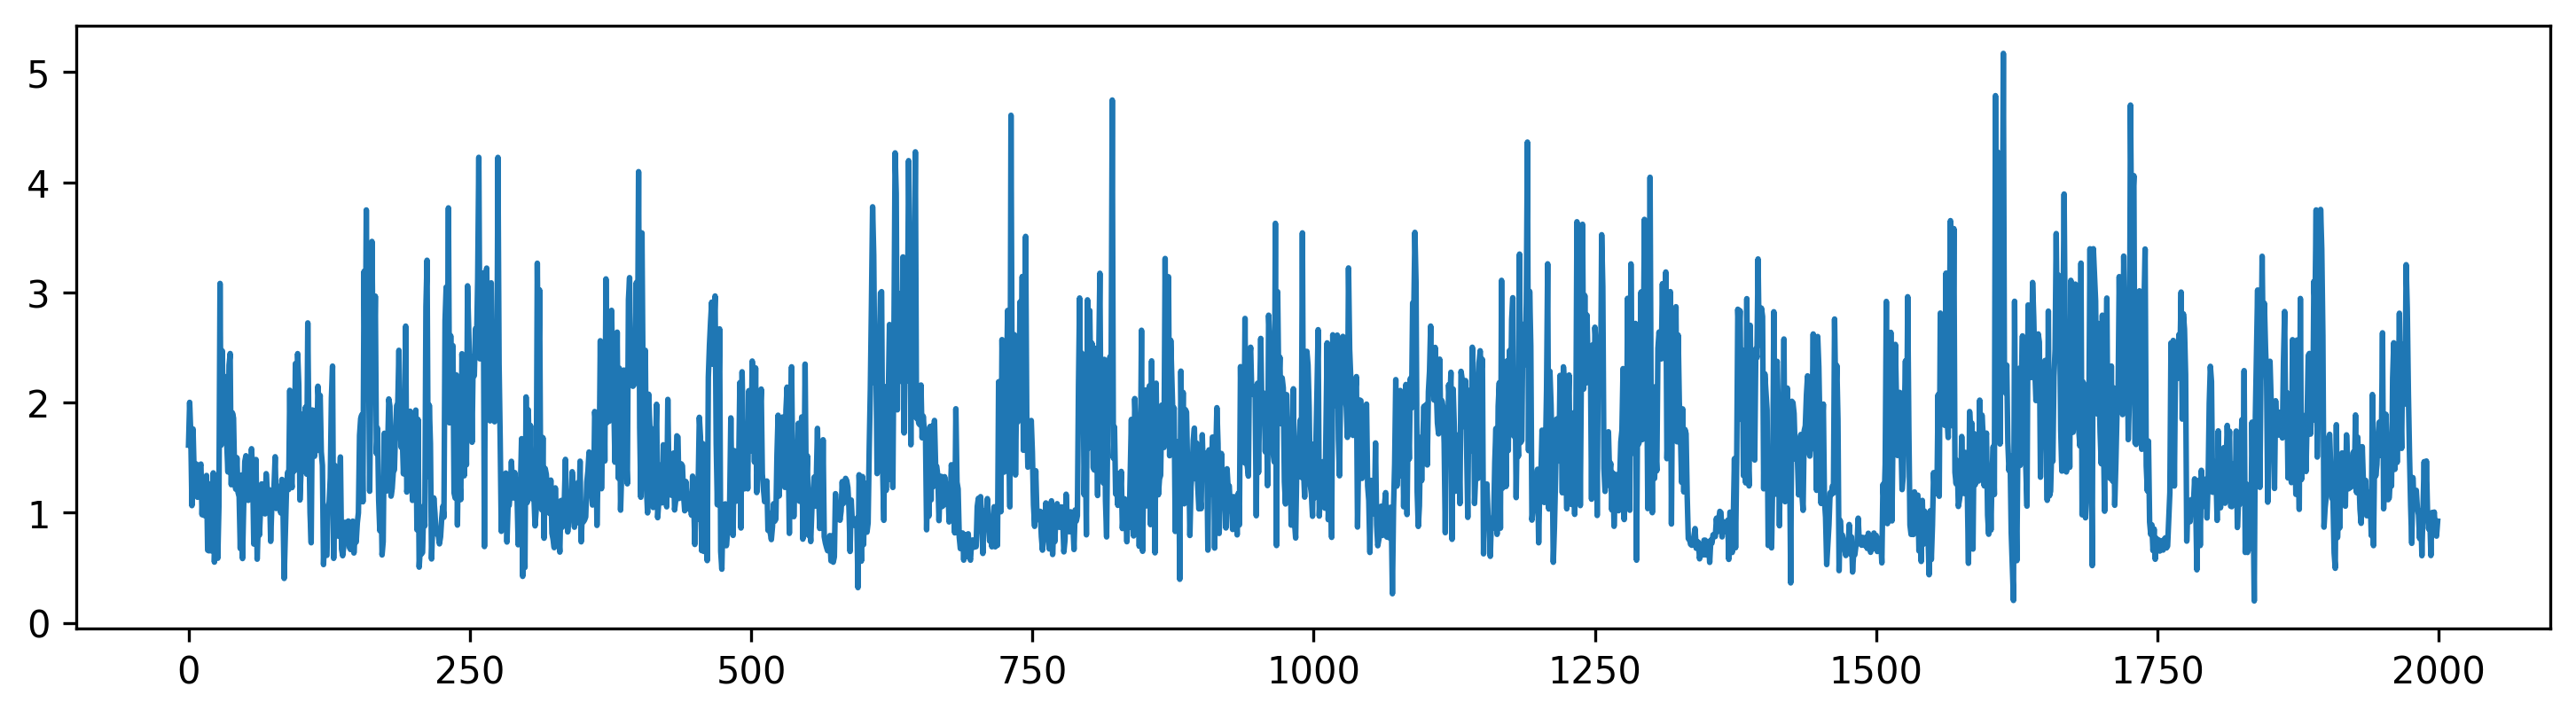

In [6]:
x = []
avg_seq = []
for i in range(0,2000):
    x.append(i)
    df_data = df[2*i:2*(i+1)]
    through = df_data['throughput']
    avg_seq.append(np.average(through))
new_data = pd.DataFrame(index=x,columns=['time','through'])
for i in range(0,len(avg_seq)):
    new_data['time'][i] = x[i]
    new_data['through'][i] = avg_seq[i]
new_data.index = new_data.time
new_data.drop('time',axis=1,inplace=True)
print(new_data)
fig = plt.figure(dpi= 300 ,figsize=(12,3))
ax = fig.add_subplot(111)
ax.plot(new_data)
plt.show()

In [7]:
#获取每秒的网络带宽（用平均值来表示）

In [8]:
model_predict = new_data[1600:]

C:\Users\16087\AppData\Local\Temp\ipykernel_6088\1842459780.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_predict['predict'] = model_fit.predict(1601, 2000)


0.4853528454474446


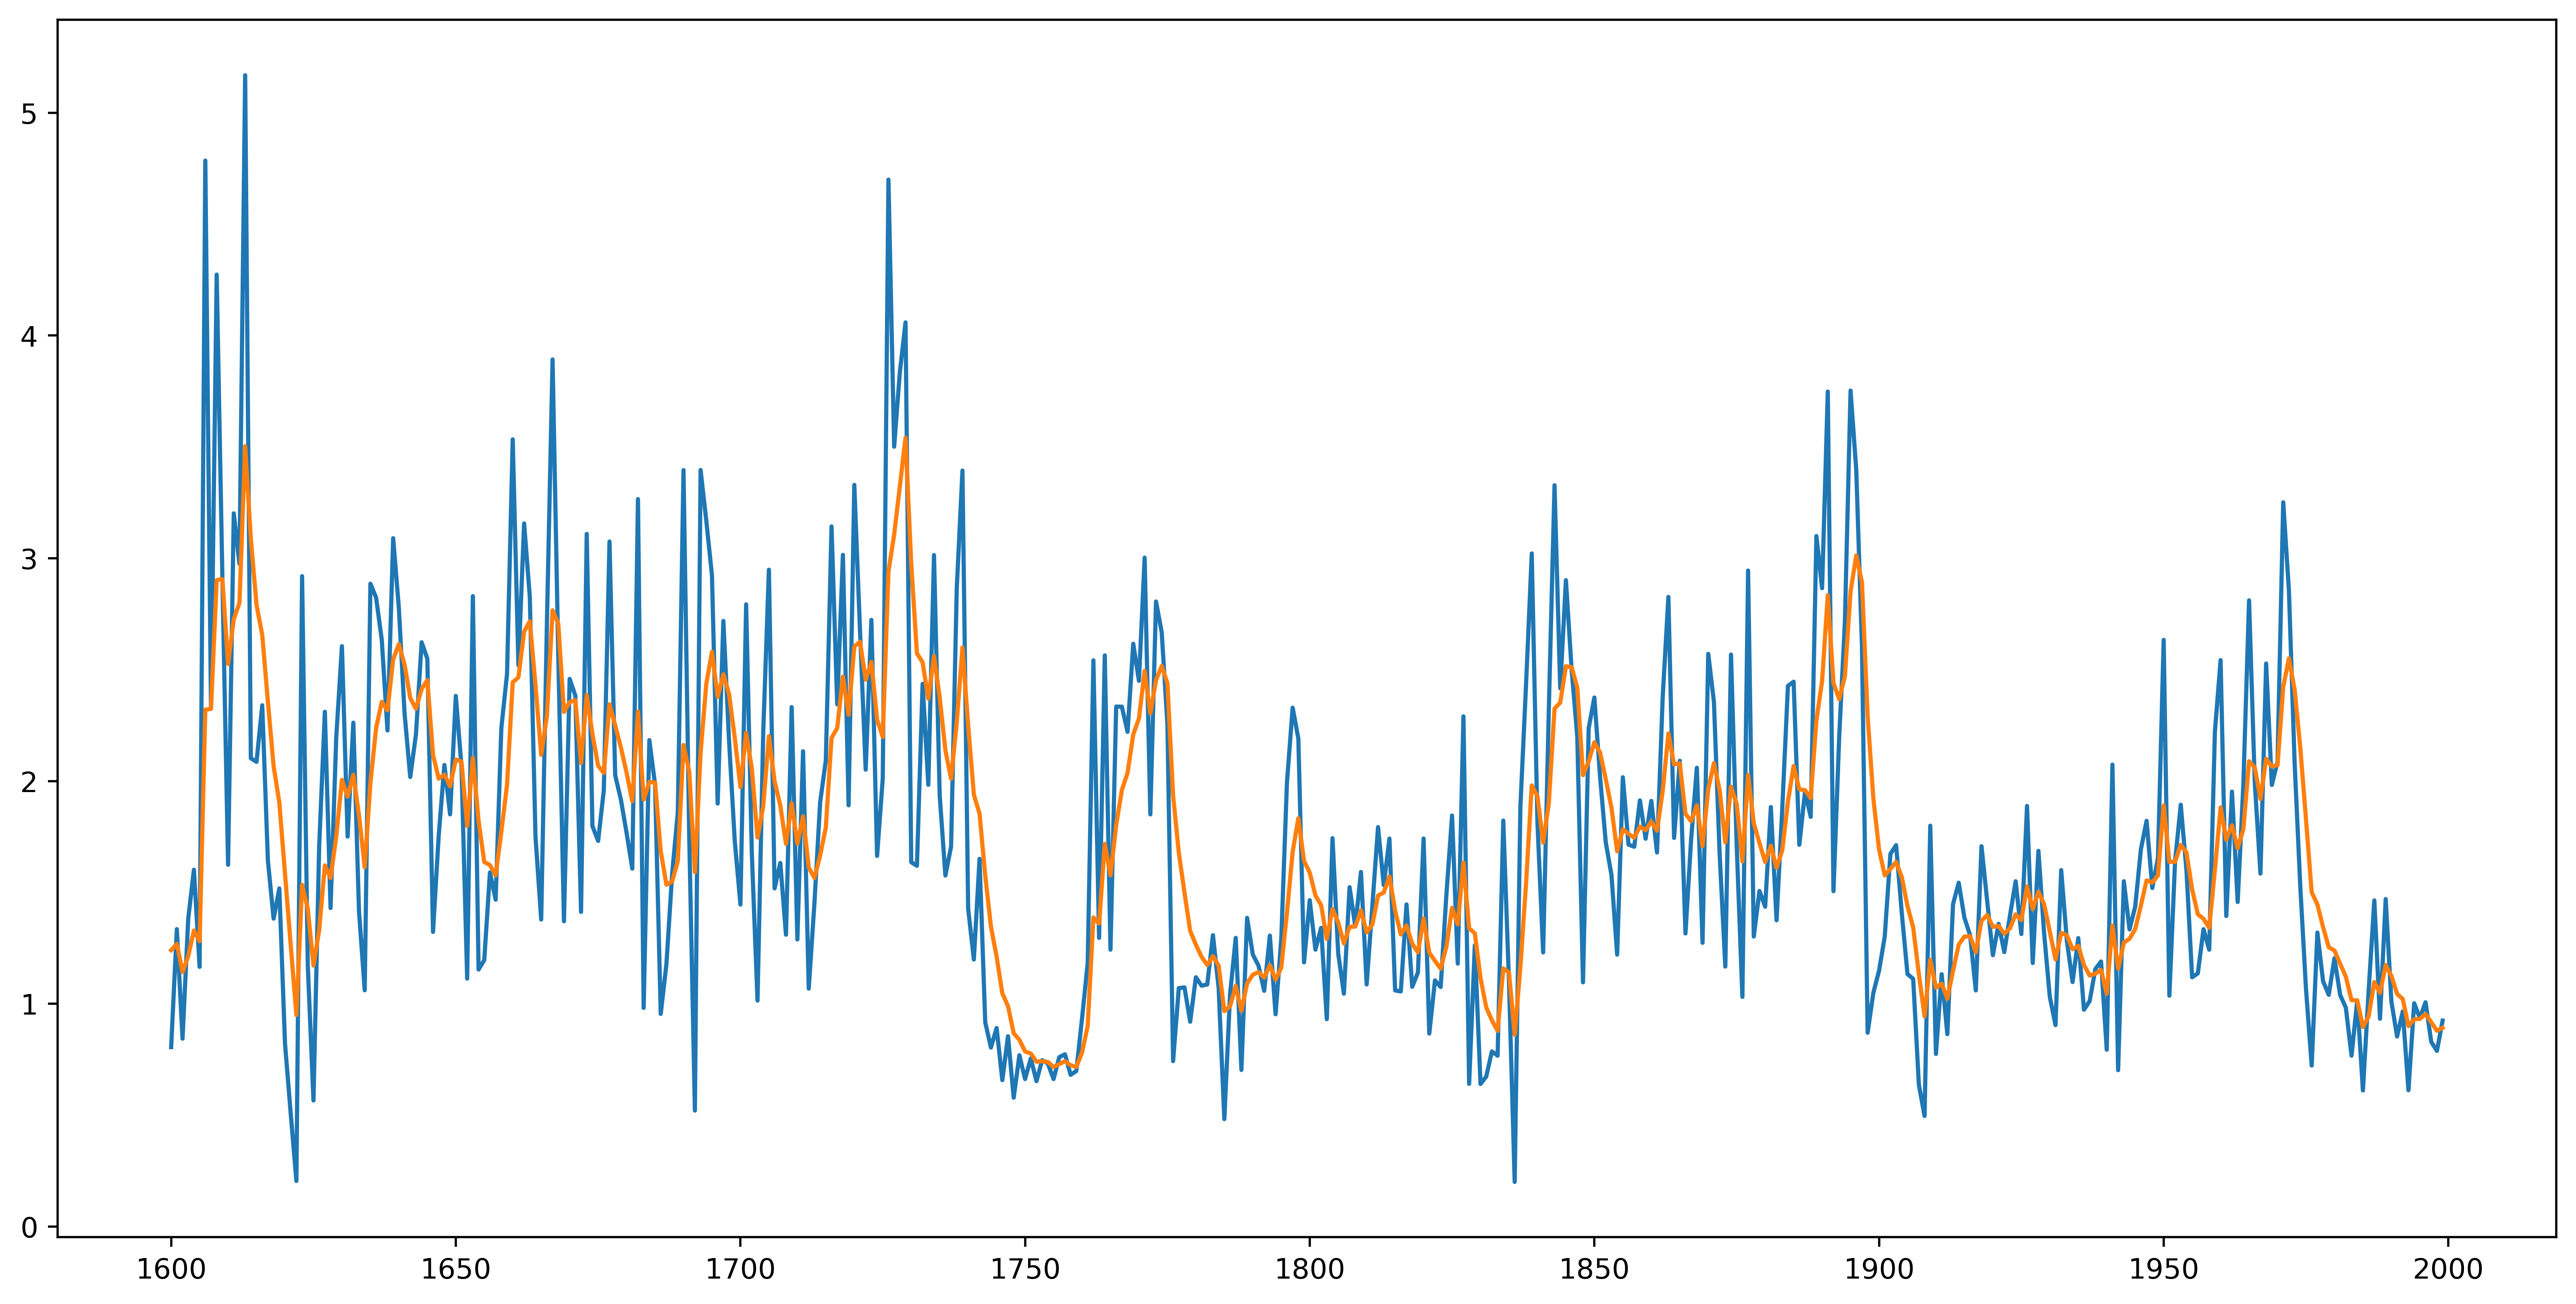

In [9]:
# SES
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# fit model
model = SimpleExpSmoothing(list(new_data['through']))
model_fit = model.fit()
# make prediction
model_predict['predict'] = model_fit.predict(1601, 2000)
rmse = np.sqrt(np.mean(np.power((model_predict['through'] - model_predict['predict']),2)))
print(rmse)
plt.figure(dpi=500,figsize=(16,8))
plt.plot(model_predict[['through','predict']])
plt.show()

C:\Users\16087\AppData\Local\Temp\ipykernel_6088\2025885591.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_predict['predict'] = model_fit.predict(1601, 2000)


0.4257802053360542


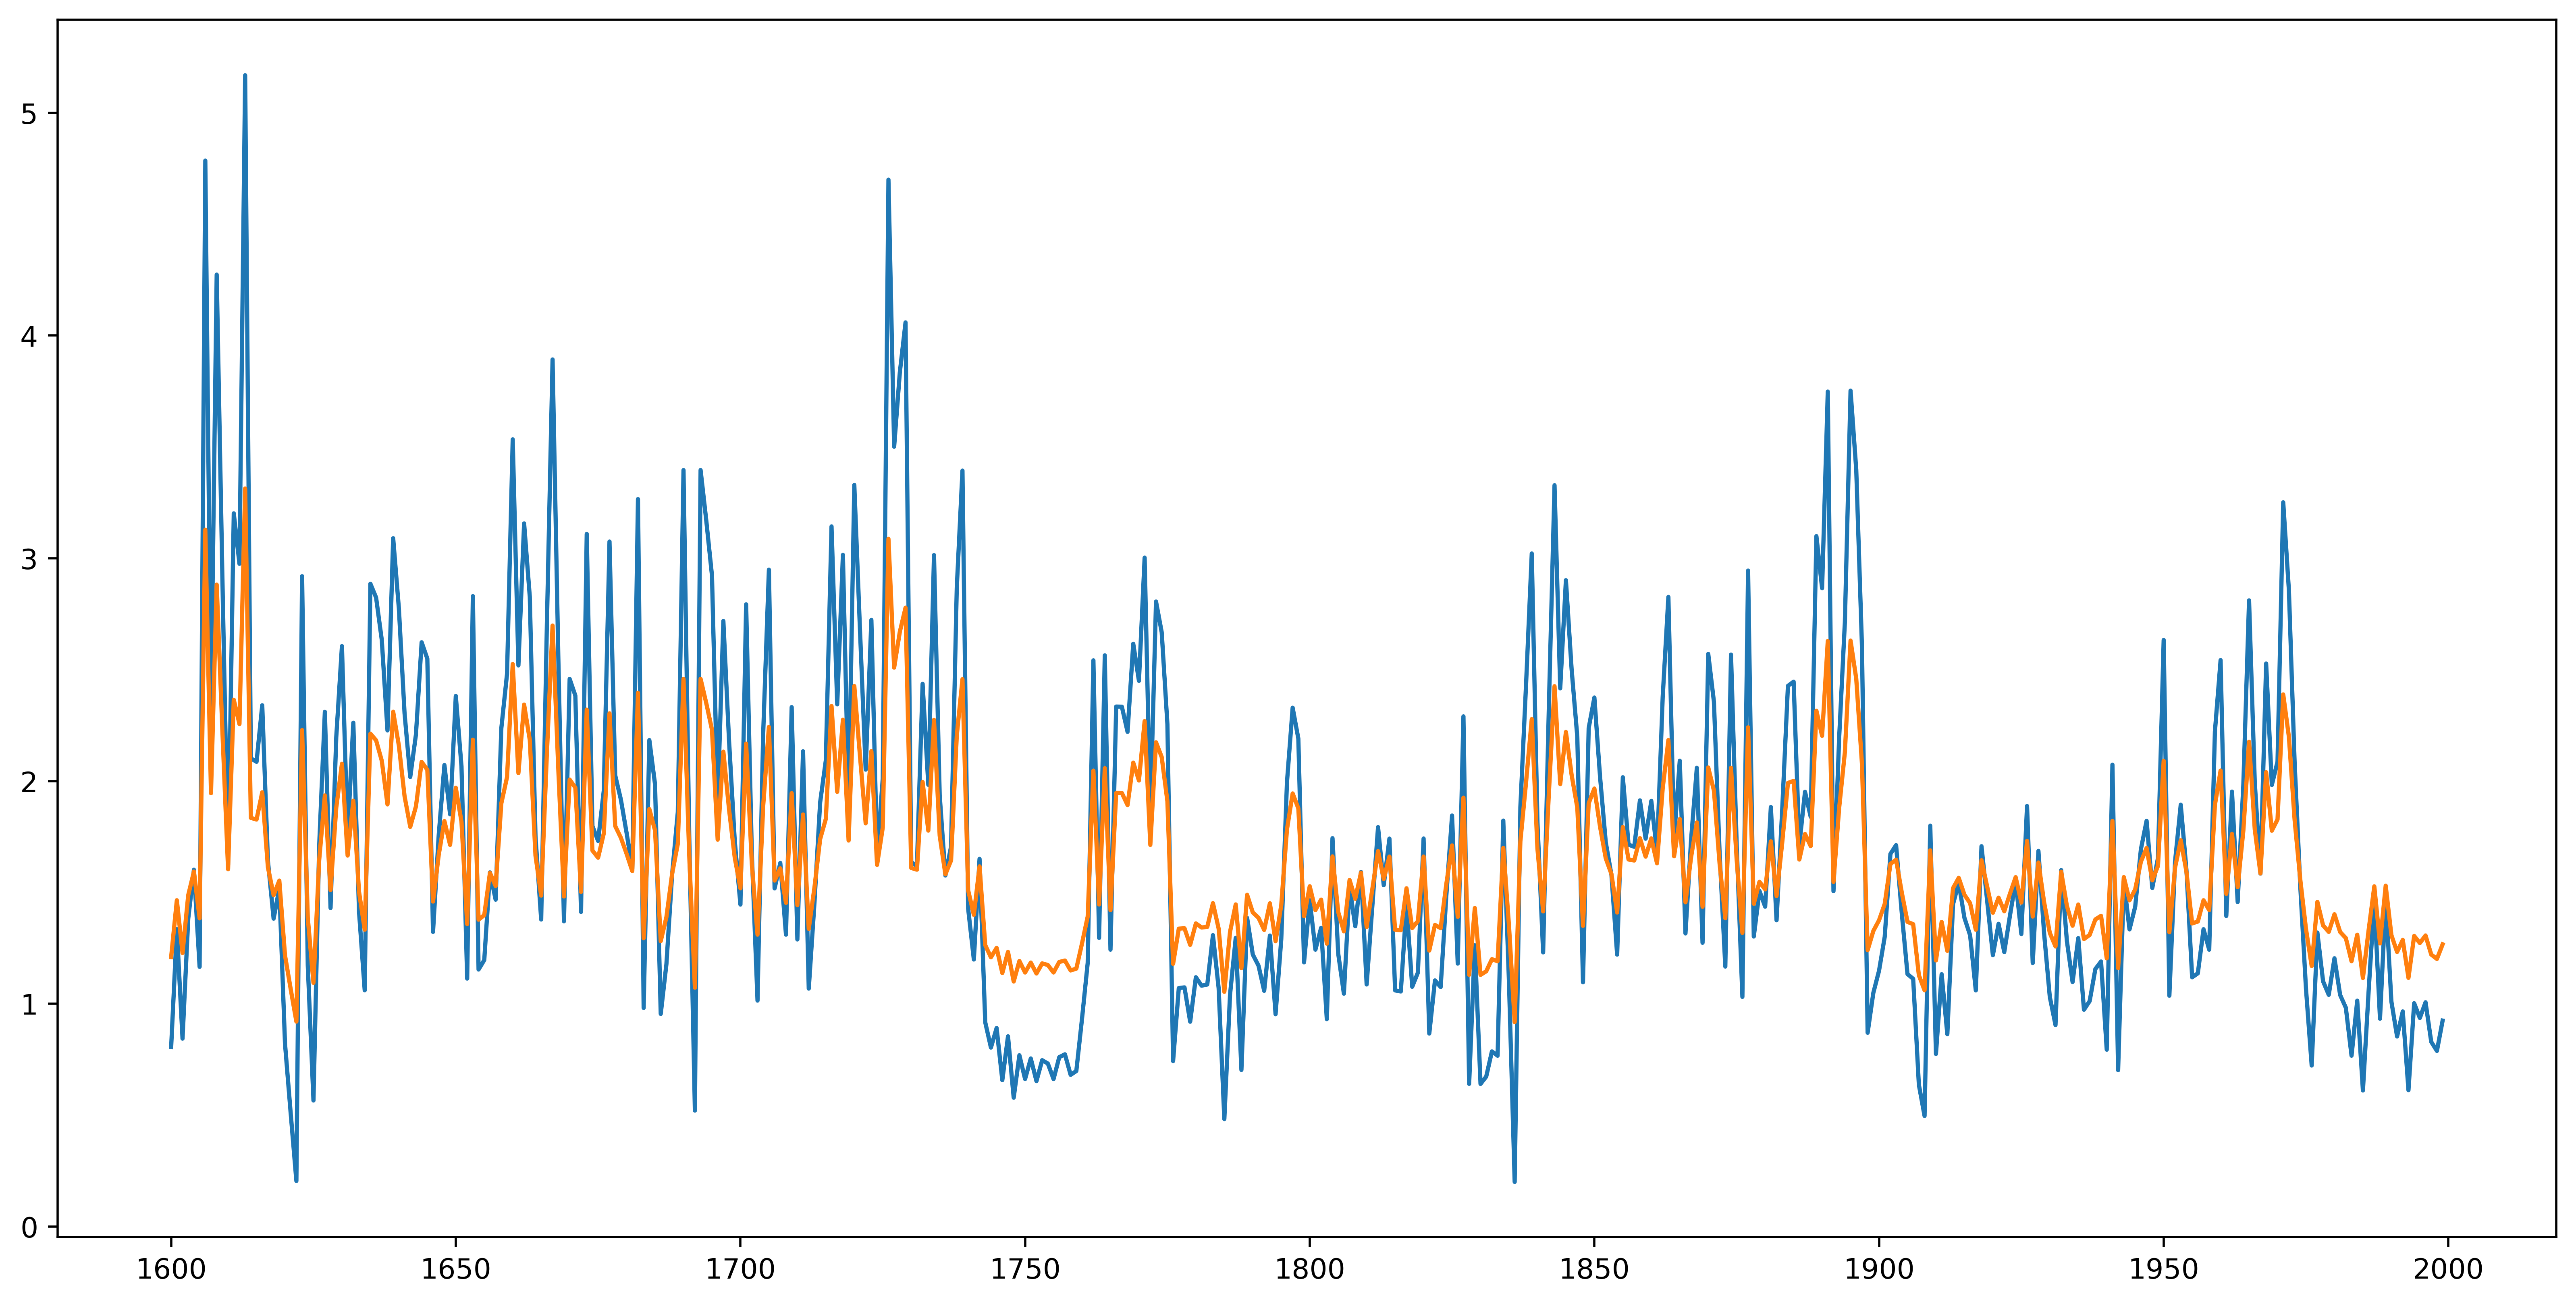

In [10]:
#AR
from statsmodels.tsa.ar_model import AutoReg
# fit model
model = AutoReg(np.asarray(new_data['through']), lags=1)
model_fit = model.fit()
# make prediction
model_predict['predict'] = model_fit.predict(1601, 2000)
rmse = np.sqrt(np.mean(np.power((model_predict['through'] - model_predict['predict']),2)))
print(rmse)
plt.figure(dpi=500,figsize=(16,8))
plt.plot(model_predict[['through','predict']])
plt.show()

C:\Users\16087\AppData\Local\Temp\ipykernel_6088\3192166120.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_predict['predictA'] = model_fit.predict(1601, 2000)


0.4257802053360542


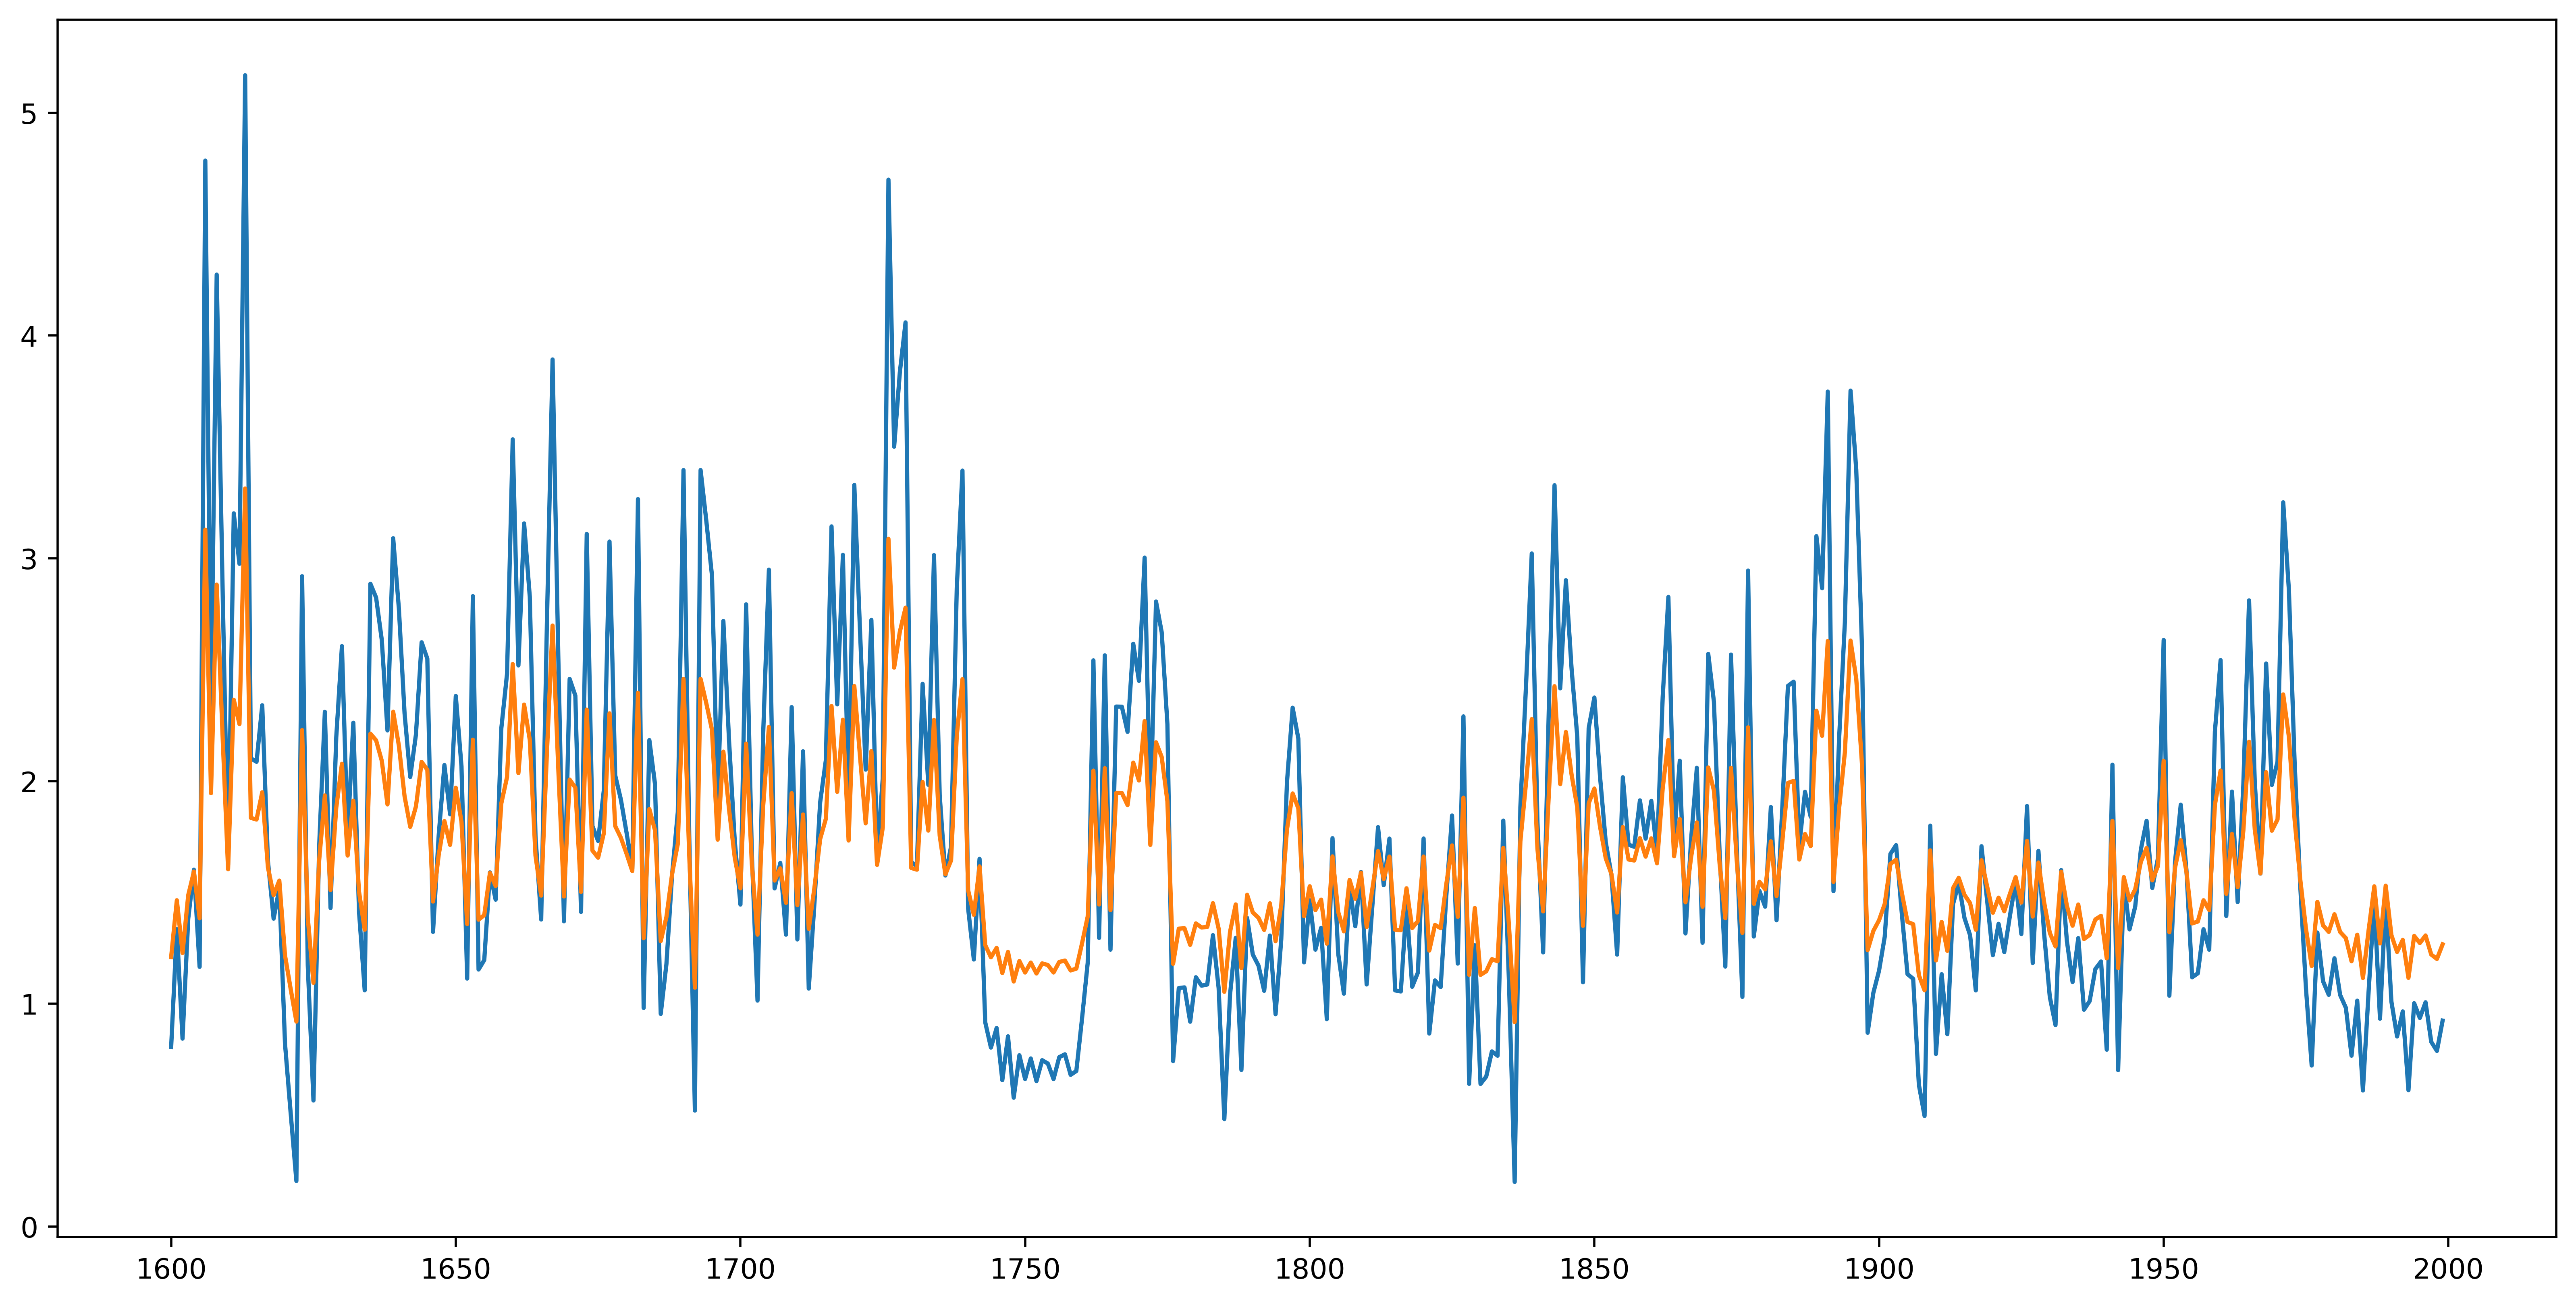

In [11]:
# MA
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(list(new_data['through']), order=(0, 0, 1))
model_fit = model.fit()
# make prediction
model_predict['predictA'] = model_fit.predict(1601, 2000)
rmse = np.sqrt(np.mean(np.power((model_predict['through'] - model_predict['predict']),2)))

print(rmse)
plt.figure(dpi=500,figsize=(16,8))
plt.plot(model_predict[['through','predict']])
plt.show()

C:\Users\16087\AppData\Local\Temp\ipykernel_6088\2155604923.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_predict['predict'] = model_fit.predict(1601, 2000)


0.49650838294281


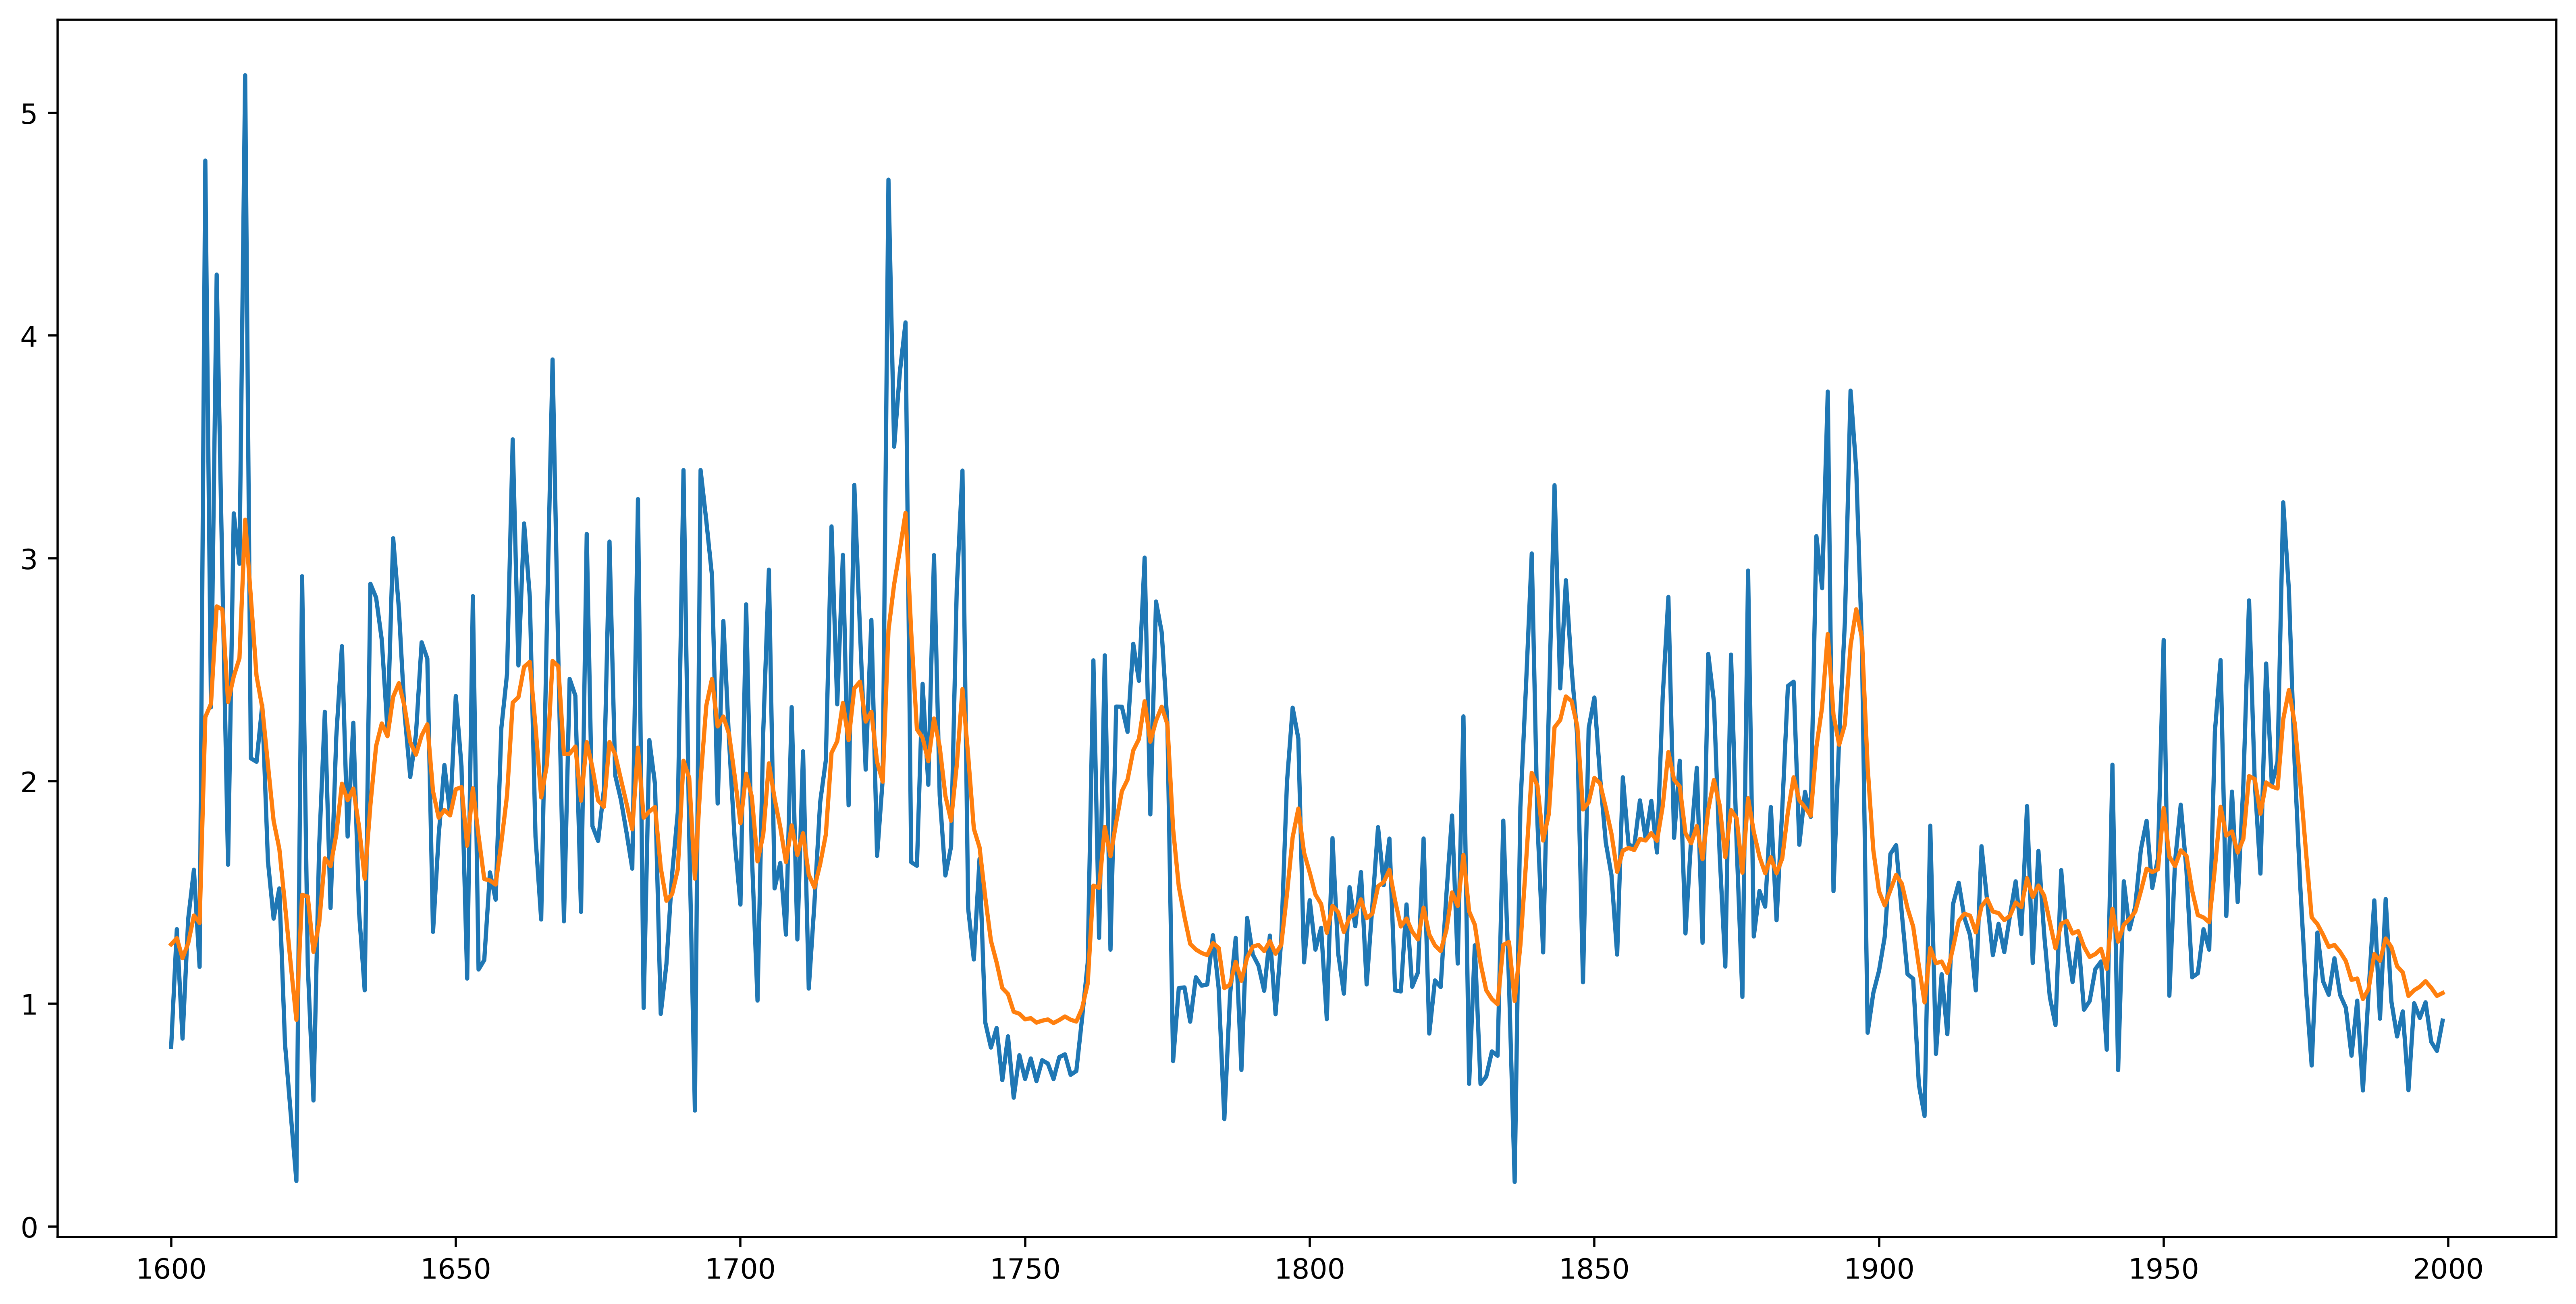

In [12]:
# ARMA
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(list(new_data['through']), order=(2, 0, 1))
model_fit = model.fit()
# make prediction
model_predict['predict'] = model_fit.predict(1601, 2000)
rmse = np.sqrt(np.mean(np.power((model_predict['through'] - model_predict['predict']),2)))

print(rmse)
plt.figure(dpi=500,figsize=(16,8))
plt.plot(model_predict[['through','predict']])
plt.show()

In [13]:
dataset = new_data.values
train = dataset[0:1600]#训练集
valid = new_data[1600:]#测试集
print(train)

[[1.6143050565132389]
 [2.0022679438280866]
 [1.7170418880075844]
 ...
 [1.6495090806619888]
 [1.722992400071722]
 [0.9782032359156947]]


In [14]:
#对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

[[0.28463493]
 [0.36271412]
 [0.30531115]
 ...
 [0.12656669]
 [0.11838296]
 [0.14575373]]


In [15]:
test = 15
x_train, y_train = [], []
for i in range(test,len(train)):
    x_train.append(scaled_data[i-test:i,0])
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print(x_train)

(1585, 15)
(1585,)
[[[0.28463493]
  [0.36271412]
  [0.30531115]
  ...
  [0.15753992]
  [0.21844596]
  [0.15596287]]

 [[0.36271412]
  [0.30531115]
  [0.17402534]
  ...
  [0.21844596]
  [0.15596287]
  [0.18536231]]

 [[0.30531115]
  [0.17402534]
  [0.31410076]
  ...
  [0.15596287]
  [0.18536231]
  [0.22916487]]

 ...

 [[0.06874075]
  [0.34590597]
  [0.30266497]
  ...
  [0.33952752]
  [0.30496568]
  [0.21016644]]

 [[0.34590597]
  [0.30266497]
  [0.32490044]
  ...
  [0.30496568]
  [0.21016644]
  [0.29171989]]

 [[0.30266497]
  [0.32490044]
  [0.09468931]
  ...
  [0.21016644]
  [0.29171989]
  [0.30650872]]]


In [16]:
#生成训练集和测试集

In [17]:
# create and fit the LSTM network
model = Sequential() # 顺序模型，核心操作是添加layer（图层）
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1)) #全连接层

model.compile(loss='mean_squared_error', optimizer='adam') #选择优化器，并指定损失函数
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

1585/1585 - 10s - loss: 0.0164 - 10s/epoch - 6ms/step


In [18]:
#生成模型

In [19]:
inputs = dataset[len(new_data) - len(valid) - test:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(test,inputs.shape[0]):
    X_test.append(inputs[i-test:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
print(X_test)

(415, 1)
(400, 15, 1)
[[[0.32490044]
  [0.09468931]
  [0.30583792]
  ...
  [0.29171989]
  [0.30650872]
  [0.15661672]]

 [[0.09468931]
  [0.30583792]
  [0.21212364]
  ...
  [0.30650872]
  [0.15661672]
  [0.12179923]]

 [[0.30583792]
  [0.21212364]
  [0.28690452]
  ...
  [0.15661672]
  [0.12179923]
  [0.22839274]]

 ...

 [[0.15742822]
  [0.11406408]
  [0.16376847]
  ...
  [0.16147662]
  [0.14814078]
  [0.16232403]]

 [[0.11406408]
  [0.16376847]
  [0.08261278]
  ...
  [0.14814078]
  [0.16232403]
  [0.12656669]]

 [[0.16376847]
  [0.08261278]
  [0.17225528]
  ...
  [0.16232403]
  [0.12656669]
  [0.11838296]]]


In [20]:
#生成测试集

In [21]:
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

13/13 [==============================] - 1s 2ms/step


In [22]:
rmse = np.sqrt(np.mean(np.power((valid[['through']] - closing_price),2)))

print(rmse)

through    0.683903
dtype: float64


C:\Users\16087\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [23]:
#用平均均方误差来衡量模型好坏

C:\Users\16087\AppData\Local\Temp\ipykernel_6088\3915005786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


<function matplotlib.pyplot.show(close=None, block=None)>

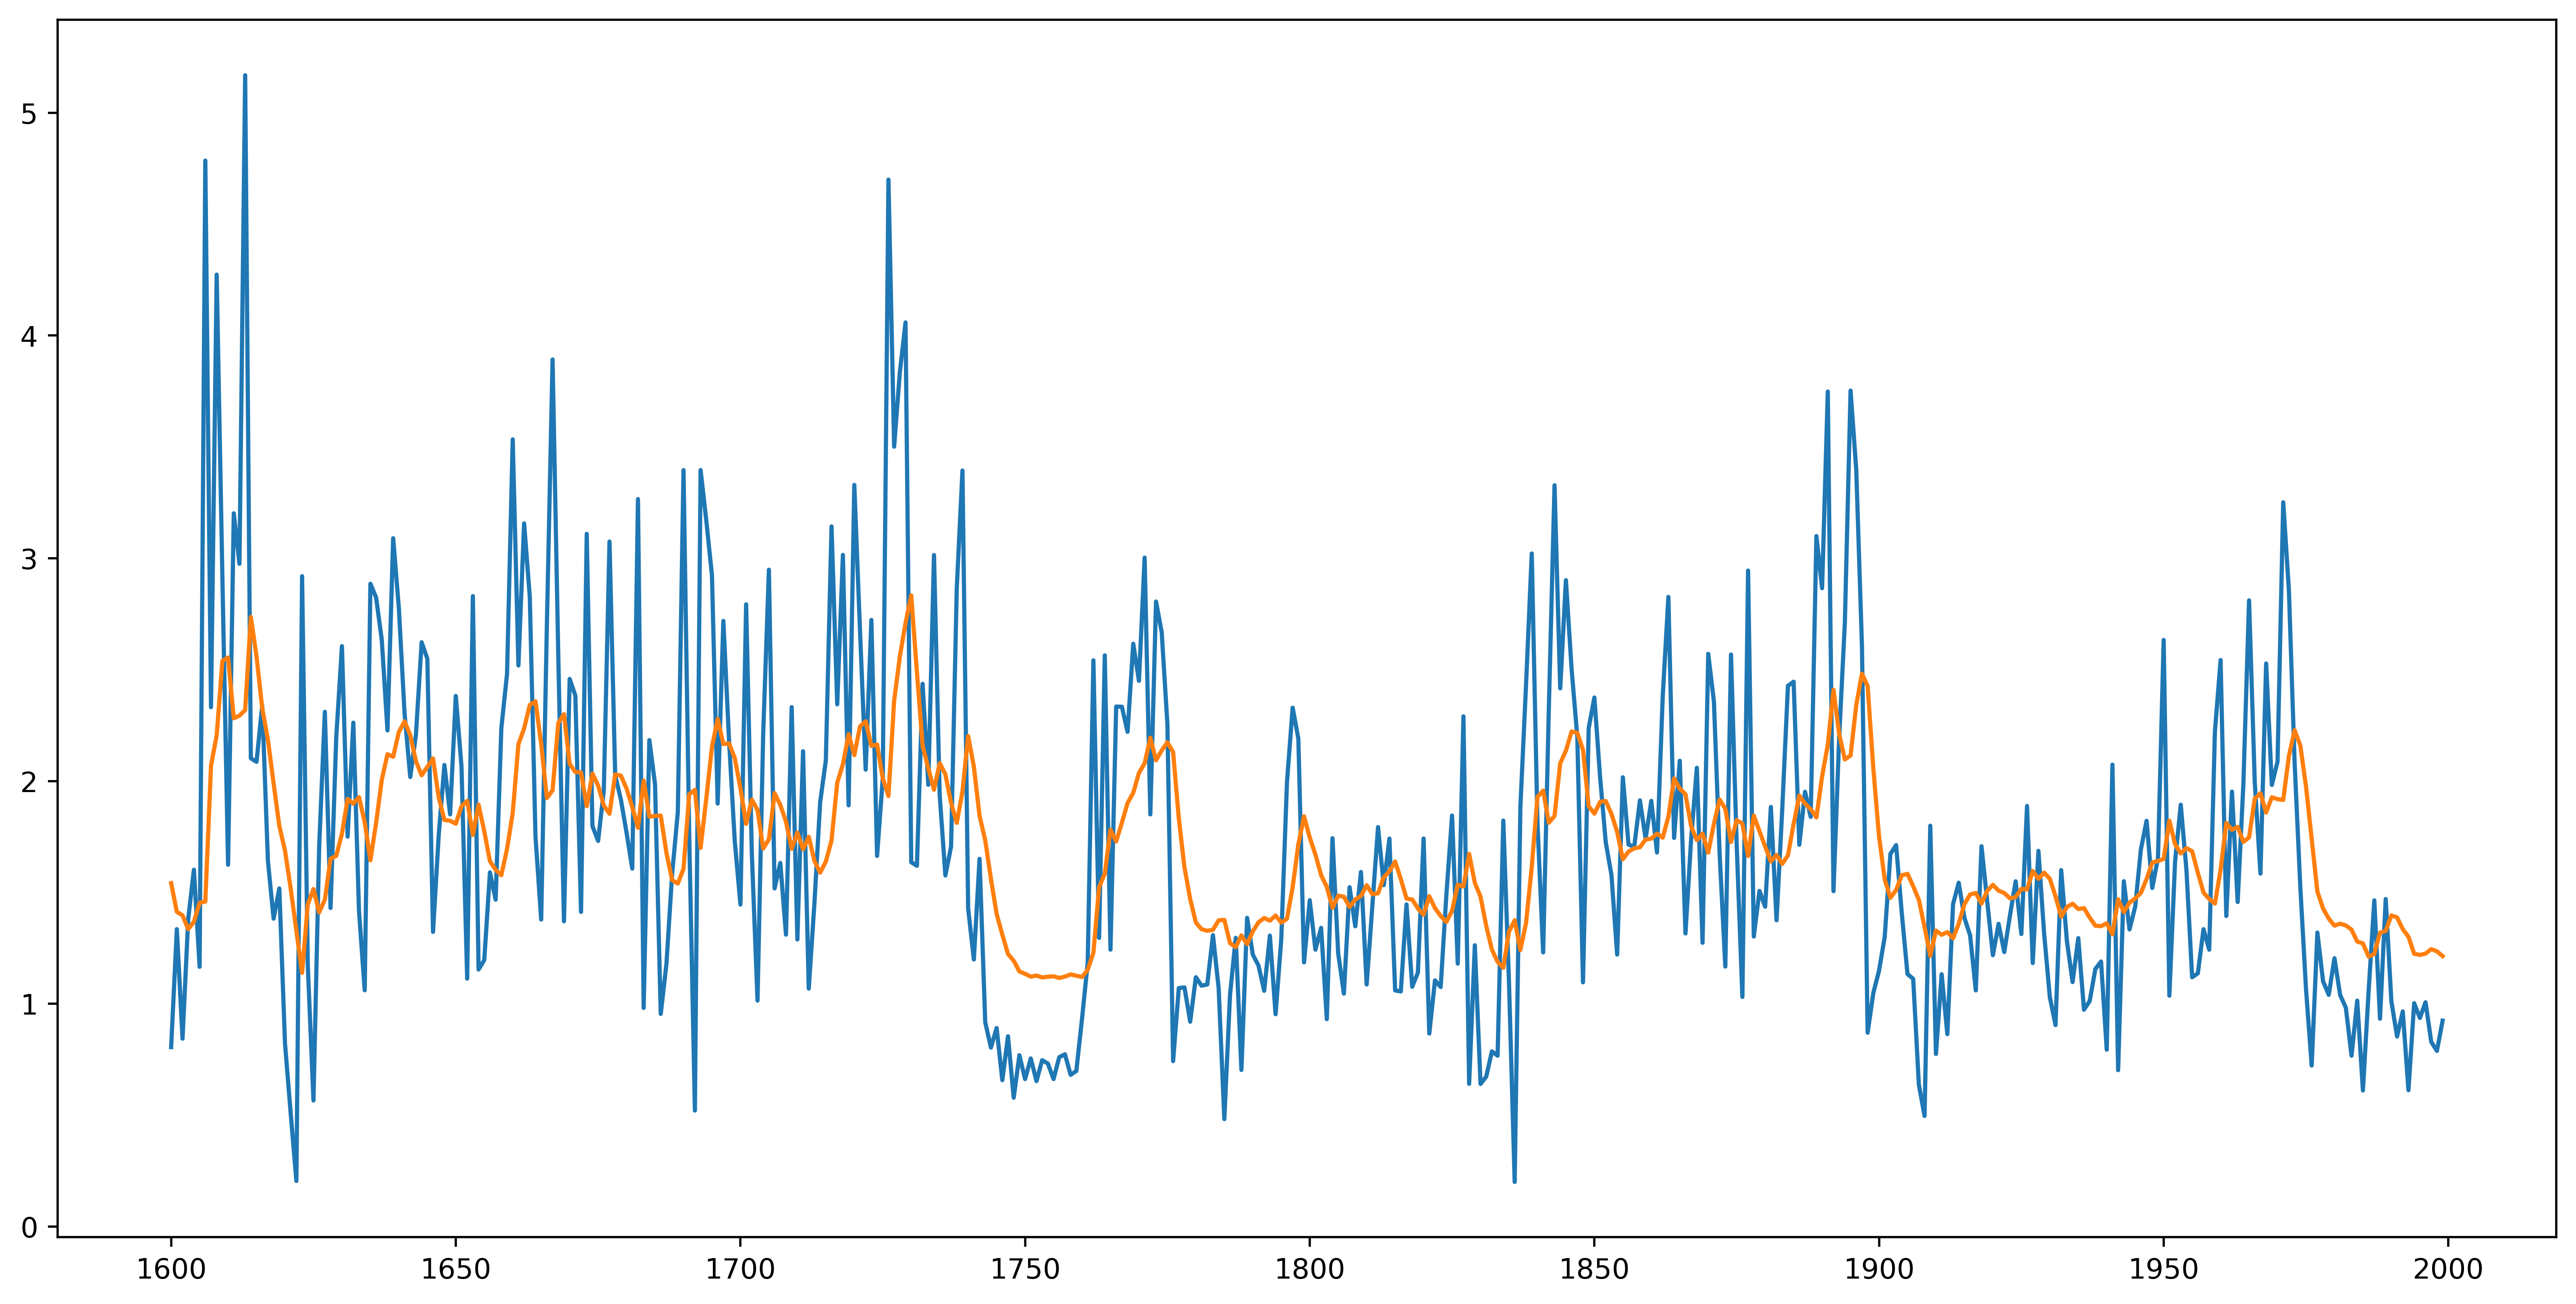

In [24]:
train = new_data[:1600]
valid = new_data[1600:]
valid['Predictions'] = closing_price

plt.figure(dpi=500,figsize=(16,8))
#plt.plot(train['through'])
plt.plot(valid[['through','Predictions']])
plt.show

In [25]:
#绘图查看模型预测效果，从上图可以看出模型可以很好的预测出网络带宽的波动趋势，但对于剧烈的波动预测并不精准